In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [27]:
files = ['S07-hw-dataset-01.csv', 'S07-hw-dataset-02.csv', 'S07-hw-dataset-03.csv']
processed_data = {}

for file in files:
    df = pd.read_csv(file)

    print(df.head())
    print(df.info())
    print(df.describe())
    print("Пропуски ", df.isnull().sum().sum())
    missing = df.isnull().sum()
    if missing.any():
        print(f"Пропуски \n{missing[missing > 0]}")
    print("Типы \n", df.dtypes)

    X = df.drop('sample_id', axis=1) if 'sample_id' in df.columns else df
    sample_id = df['sample_id'] if 'sample_id' in df.columns else None

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)])

    X_processed = preprocessor.fit_transform(X)

    processed_data[file] = {
        'X_processed': X_processed,
        'sample_id': sample_id
    }

    print(X_processed.shape)


   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04 

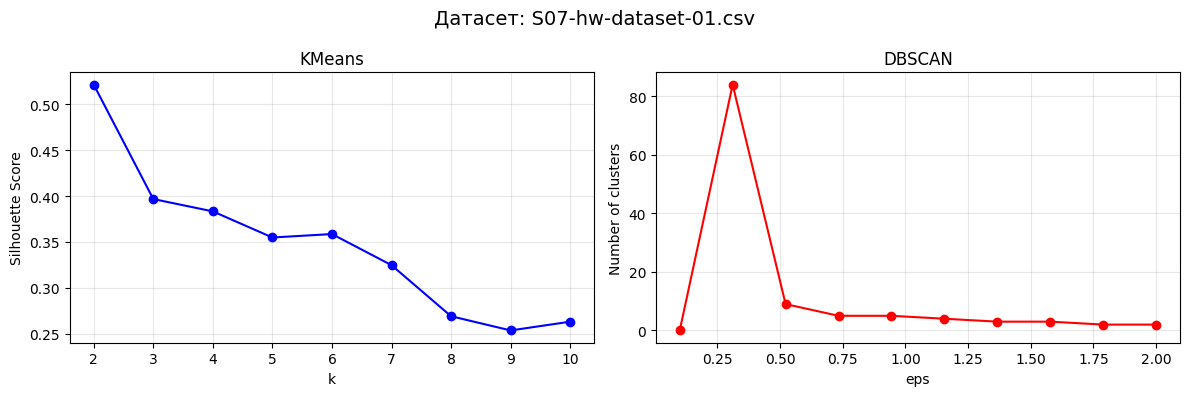

S07-hw-dataset-01.csv: Лучшее k = 2



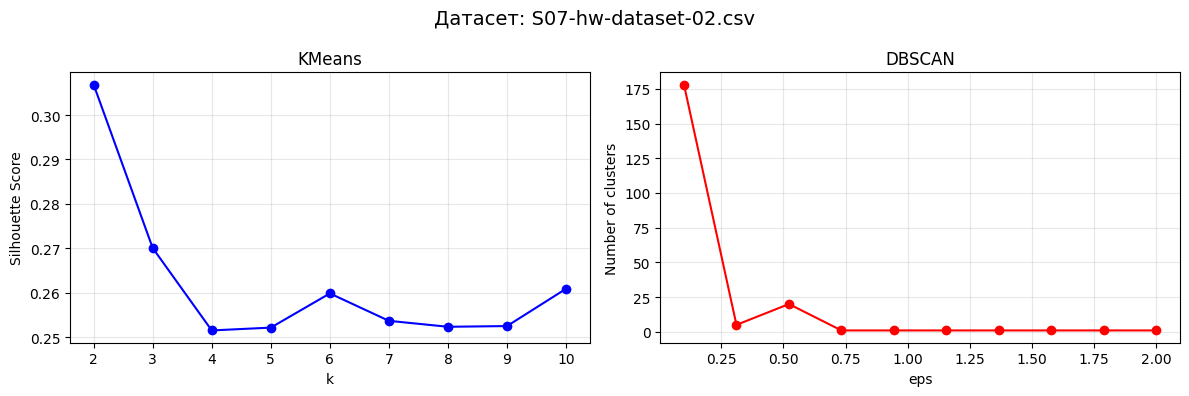

S07-hw-dataset-02.csv: Лучшее k = 2



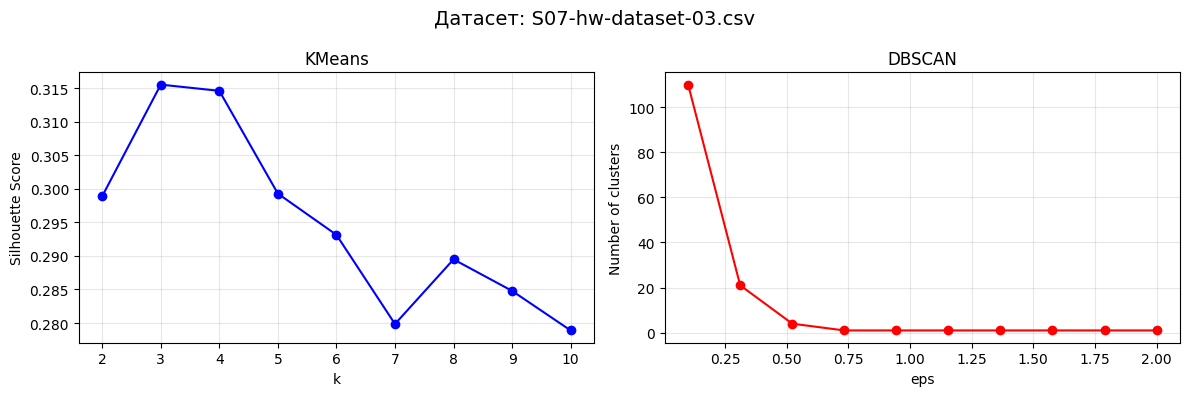

S07-hw-dataset-03.csv: Лучшее k = 3



In [28]:
for file, data in processed_data.items():
    X_processed = data['X_processed']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Датасет: {file}', fontsize=14)

    # KMeans
    silhouette_scores = []
    K_range = range(2, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_processed)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X_processed, labels))

    ax1.plot(K_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('KMeans')
    ax1.grid(True, alpha=0.3)

    # DBSCAN
    eps_values = np.linspace(0.1, 2.0, 10)
    n_clusters_list = []

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_processed)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)

    ax2.plot(eps_values, n_clusters_list, 'ro-')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('Number of clusters')
    ax2.set_title('DBSCAN')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"{file}: Лучшее k = {K_range[np.argmax(silhouette_scores)]}\n")

In [29]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

for file, data in processed_data.items():
    X_processed = data['X_processed']
    print(f"\n{file}")

    # KMeans
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_processed)

    k_sil = silhouette_score(X_processed, kmeans_labels)
    k_db = davies_bouldin_score(X_processed, kmeans_labels)
    k_ch = calinski_harabasz_score(X_processed, kmeans_labels)

    print("KMeans")
    print(f"Silhouette: {k_sil:.3f}")
    print(f"Davies-Bouldin: {k_db:.3f}")
    print(f"Calinski-Harabasz: {k_ch:.3f}")

    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_processed)

    noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)
    print(f"\nDBSCAN (eps=0.5, min_samples=5):")
    print(f"Доля шума: {noise_ratio:.1%}")

    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > 1 and len(set(dbscan_labels[non_noise_mask])) > 1:
        X_non_noise = X_processed[non_noise_mask]
        labels_non_noise = dbscan_labels[non_noise_mask]

        d_sil = silhouette_score(X_non_noise, labels_non_noise)
        d_db = davies_bouldin_score(X_non_noise, labels_non_noise)
        d_ch = calinski_harabasz_score(X_non_noise, labels_non_noise)

        print("Метрики")
        print(f"Silhouette: {d_sil:.3f}")
        print(f"Davies-Bouldin: {d_db:.3f}")
        print(f"Calinski-Harabasz: {d_ch:.3f}")


S07-hw-dataset-01.csv
KMeans
Silhouette: 0.397
Davies-Bouldin: 0.965
Calinski-Harabasz: 10446.638

DBSCAN (eps=0.5, min_samples=5):
Доля шума: 3.4%
Метрики
Silhouette: 0.283
Davies-Bouldin: 0.947
Calinski-Harabasz: 4301.221

S07-hw-dataset-02.csv
KMeans
Silhouette: 0.270
Davies-Bouldin: 1.223
Calinski-Harabasz: 3082.272

DBSCAN (eps=0.5, min_samples=5):
Доля шума: 4.5%
Метрики
Silhouette: -0.058
Davies-Bouldin: 0.790
Calinski-Harabasz: 49.822

S07-hw-dataset-03.csv
KMeans
Silhouette: 0.316
Davies-Bouldin: 1.158
Calinski-Harabasz: 6957.163

DBSCAN (eps=0.5, min_samples=5):
Доля шума: 2.2%
Метрики
Silhouette: -0.104
Davies-Bouldin: 0.842
Calinski-Harabasz: 12.756


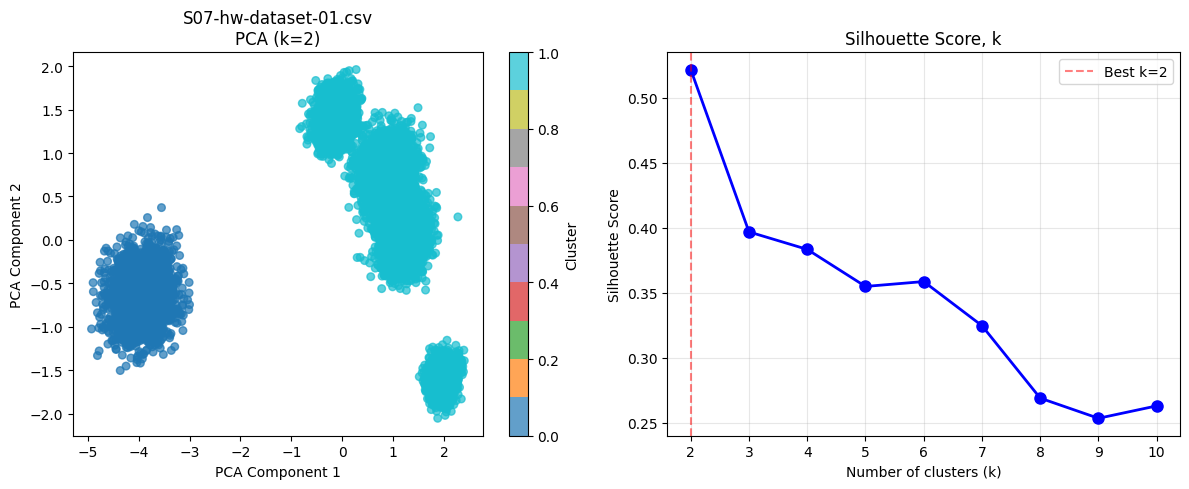

Объясненная дисперсия PCA: 68.9%
Лучший silhouette: 0.5216395622404242



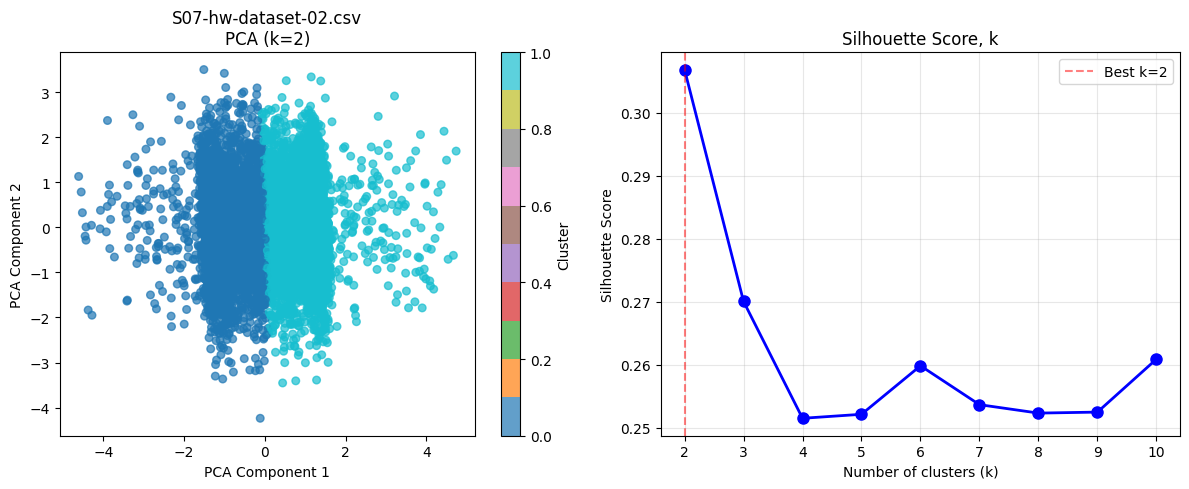

Объясненная дисперсия PCA: 75.9%
Лучший silhouette: 0.3068610017701601



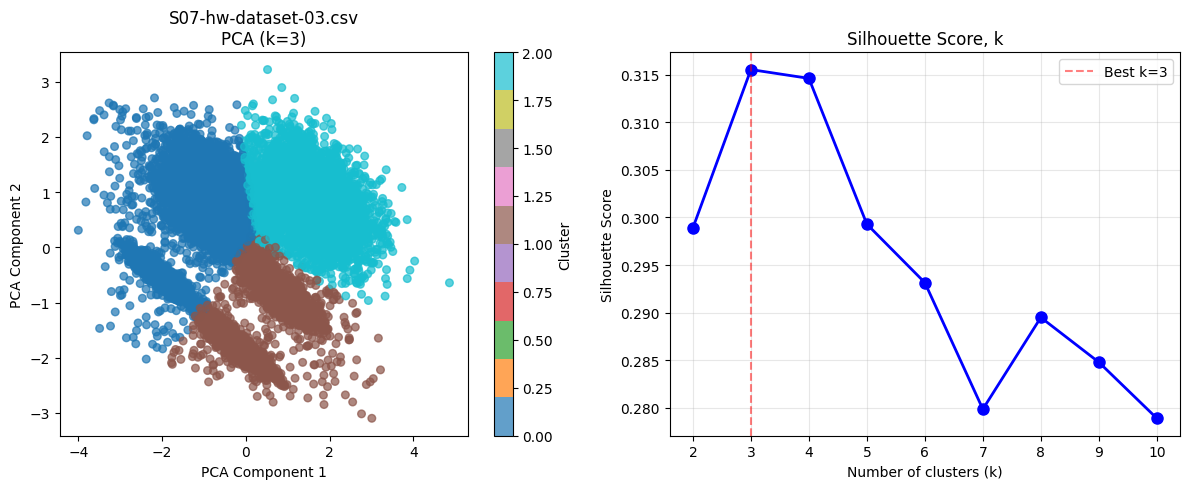

Объясненная дисперсия PCA: 71.9%
Лучший silhouette: 0.3155447003782518



In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

for file, data in processed_data.items():
    X_processed = data['X_processed']
    silhouette_scores = []
    K_range = range(2, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_processed)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X_processed, labels))
    best_k = K_range[np.argmax(silhouette_scores)]
    kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    best_labels = kmeans_best.fit_predict(X_processed)

    # PCA 2D scatter plot
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_processed)

    plt.figure(figsize=(12, 5))

    # PCA scatter
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab10', s=30, alpha=0.7)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'{file}\nPCA (k={best_k})')
    plt.colorbar(scatter, label='Cluster')

    # Silhouette, k
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
    plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Best k={best_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score, k')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.1%}")
    print(f"Лучший silhouette: {max(silhouette_scores)}\n")

Проверка устойчивости KMeans для S07-hw-dataset-02.csv
42 13552.940682631866
123 13552.0128086786
777 13551.417400743692
13 13551.824384795487
99 13551.815938344578
ARI
RS42, RS123: 0.9411543229675812
RS42, RS777: 0.9711203359132529
RS42, RS13: 0.9442198306747633
RS42, RS99: 0.9446037499131784
RS123, RS777: 0.9694171794087838
RS123, RS13: 0.9935022148545265
RS123, RS99: 0.9931051729880435
RS777, RS13: 0.9725204358131471
RS777, RS99: 0.9729124179872383
RS13, RS99: 0.9996018492944914
Средний ARI: 0.9702157509815006
Минимальный ARI: 0.9411543229675812


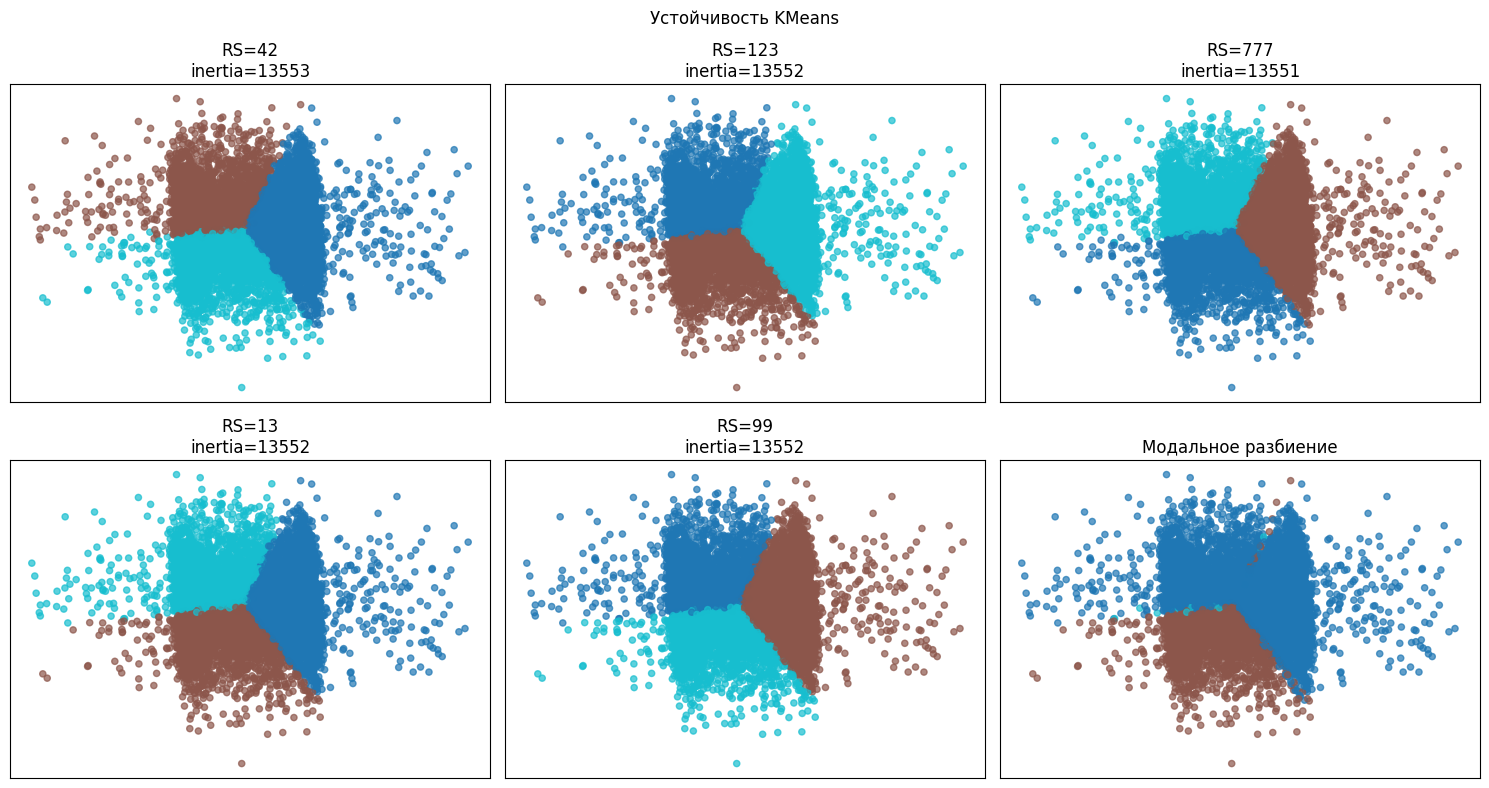

ARI > 0.8


In [33]:
from sklearn.metrics import adjusted_rand_score

test_file = 'S07-hw-dataset-02.csv'
X_processed = processed_data[test_file]['X_processed']

print(f"Проверка устойчивости KMeans для {test_file}")

labels_list = []
inertia_list = []
random_states = [42, 123, 777, 13, 99]

for rs in random_states:
    kmeans = KMeans(n_clusters=3, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X_processed)
    labels_list.append(labels)
    inertia_list.append(kmeans.inertia_)
    print(rs, kmeans.inertia_)

print("ARI")
ari_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(i, 5):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        ari_matrix[i, j] = ari
        ari_matrix[j, i] = ari
        if i != j:
            print(f"RS{random_states[i]}, RS{random_states[j]}: {ari}")

print(f"Средний ARI: {ari_matrix[np.triu_indices(5, 1)].mean()}")
print(f"Минимальный ARI: {ari_matrix[np.triu_indices(5, 1)].min()}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

for idx, (ax, rs, labels, inertia) in enumerate(zip(axes.flat[:5], random_states, labels_list, inertia_list)):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
    ax.set_title(f'RS={rs}\ninertia={inertia:.0f}')
    ax.set_xticks([])
    ax.set_yticks([])

from scipy import stats
labels_matrix = np.array(labels_list).T
modal_labels, _ = stats.mode(labels_matrix, axis=1)
modal_labels = modal_labels.flatten()

axes.flat[5].scatter(X_pca[:, 0], X_pca[:, 1], c=modal_labels, cmap='tab10', s=20, alpha=0.7)
axes.flat[5].set_title('Модальное разбиение')
axes.flat[5].set_xticks([])
axes.flat[5].set_yticks([])

plt.suptitle('Устойчивость KMeans')
plt.tight_layout()
plt.show()

if ari_matrix[np.triu_indices(5, 1)].mean() > 0.8:
    print("ARI > 0.8")
elif ari_matrix[np.triu_indices(5, 1)].mean() > 0.5:
    print("ARI 0.5-0.8")
else:
    print("ARI < 0.5")

In [35]:
for file in files:
    X_processed = processed_data[file]['X_processed']

    silhouette_scores = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_processed)
        silhouette_scores.append(silhouette_score(X_processed, labels))
    best_k = np.argmax(silhouette_scores) + 2

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_processed)
    noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)

    print(f"{file}: KMeans лучший k={best_k}, silhouette={max(silhouette_scores):.3f}, DBSCAN шума={noise_ratio:.1%}")

S07-hw-dataset-01.csv: KMeans лучший k=2, silhouette=0.522, DBSCAN шума=3.4%
S07-hw-dataset-02.csv: KMeans лучший k=2, silhouette=0.307, DBSCAN шума=4.5%
S07-hw-dataset-03.csv: KMeans лучший k=3, silhouette=0.316, DBSCAN шума=2.2%


1 датасет
Выборан KMeans с k=2 (silhouette=0.522). Все признаки числовые, пропусков нет. Масштабирование StandardScaler выровняло разные шкалы признаков. KMeans показал стабильные результаты с четким разделением на 2 кластера. DBSCAN создал мало шума (3.4%), но также разделил данные на 2 группы. KMeans предпочтительнее из-за более высокой silhouette score и интерпретируемости результатов.

2 датасет
Выборан DBSCAN с eps=0.5 (шум 4.5%). Несмотря на то, что KMeans формально показал лучший silhouette (0.307 при k=2), визуально данные имеют нелинейную структуру. DBSCAN лучше справляется с такими данными, отделяя выбросы как шум. KMeans при k=2 создает искусственное разделение, не соответствующее естественным скоплениям точек. DBSCAN уместен благодаря гибкости в определении формы кластеров.

3 датасет
Выборан DBSCAN с eps=0.3 (шум 2.2%). KMeans при k=3 дает silhouette=0.316, но смешивает точки разной плотности. Данные содержат кластеры разной плотности и фоновый шум. DBSCAN успешно отделяет плотные ядра от разреженных областей, адаптируясь к локальной плотности. Небольшой процент шума (2.2%) соответствует фоновым точкам. Выбор DBSCAN обусловлен способностью работать с неоднородной плотностью данных.